Since production data is annual, **start out** by making annual predictions

Also, see what happens when including pre-quota data (with ending stocks)

In [1]:
from capstone_modules import Production_Data, Temperature_Data, ICO_Composite_Indicator

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Import data

In [2]:
master_dataframe = pd.DataFrame()

# Import production data
production = Production_Data()
ICO_categories = production.ICO_categories
for category in ICO_categories:
    temp_df = production.get_aggregate_production_data_by_ICO_category(category)
    temp_df.name = category + " Production (60 kg bags)"
    master_dataframe = pd.concat([master_dataframe, temp_df[temp_df.index > 1960]], axis = 1)

# Import ICO composite indicator index data
# ICO_composite_indicator = ICO_Composite_Indicator_Index()
ICO_composite_indicator = pd.read_csv("../datasets/capstone/ICO composite indicator index since 1960.csv")
ICO_composite_indicator = ICO_composite_indicator.set_index("Unnamed: 0")
ICO_composite_indicator.columns = ["ICO Composite Indicator (US cents/lb)"]
del ICO_composite_indicator.index.name
    
master_dataframe.index = pd.to_datetime(master_dataframe.index, format = "%Y").values
master_dataframe = ICO_composite_indicator.merge(master_dataframe, left_index = True, right_index = True)

In [3]:
master_dataframe = master_dataframe[master_dataframe.index.year > 1989]
master_dataframe.head()

,ICO Composite Indicator (US cents/lb),Brazilian Naturals Production (60 kg bags),Colombian Milds Production (60 kg bags),Other Milds Production (60 kg bags),Robustas Production (60 kg bags)
1990-01-01,63.18,26116000.0,15038000.0,26635000.0,21072000.0
1991-01-01,70.12,30250000.0,15953000.0,24762000.0,22926000.0
1992-01-01,61.23,27220000.0,19483000.0,26167000.0,24415000.0
1993-01-01,58.40,22935000.0,16165000.0,24799000.0,23315000.0
1994-01-01,69.06,27932000.0,12628000.0,23496000.0,23302000.0


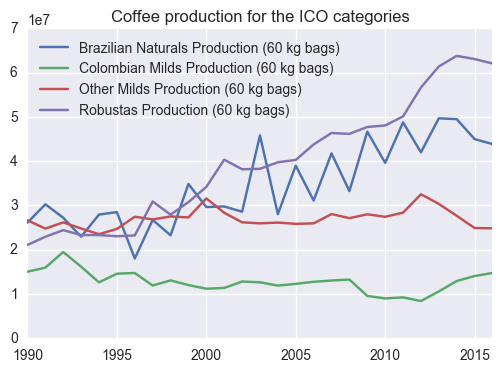

In [4]:
master_dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).plot()
plt.title("Coffee production for the ICO categories")
plt.show()

### Try predicting ICO composite indicator values from previous year's production values

In [5]:
def simple_linear_model_with_previous_production(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe["ICO Composite Indicator (US cents/lb)"].iloc[1:]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    
    linear_model = LinearRegression()
    linear_model.fit(train_X, train_y)
        
    train_y.plot()
    plt.scatter(x = test_y.index, y = linear_model.predict(test_X), c ="r")
    plt.title("Linear Regression Model")
    plt.show()

    print("Linear model score: {}".format(linear_model.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(linear_model, X, y, cv = 10).mean()))

    if show_actual_vs_predicted == True:
        plt.scatter(linear_model.predict(test_X), test_y)
        plt.xlabel("Predicted ICO composite indicator values")
        plt.ylabel("Actual ICO composite indicator values")
        plt.title("Modeling ICO composite indicator from categories")
        plt.show()   
        
def random_forest_model_with_previous_production(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe["ICO Composite Indicator (US cents/lb)"].iloc[1:]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)

    random_forest_reg = RandomForestRegressor(n_estimators = 100)
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score: {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    pd.DataFrame(data = random_forest_reg.feature_importances_, 
             index = dataframe.dropna(thresh = (dataframe.shape[0] - 2), 
                                           axis = 'columns').columns[1:]).plot.barh()
    plt.title("Feature importance")
    plt.show()
    
    if show_actual_vs_predicted == True:
        plt.scatter(random_forest_reg.predict(test_X), test_y)
        plt.xlabel("Predicted ICO composite indicator values")
        plt.ylabel("Actual ICO composite indicator values")
        plt.title("Modeling ICO composite indicator from categories")
        plt.show()   


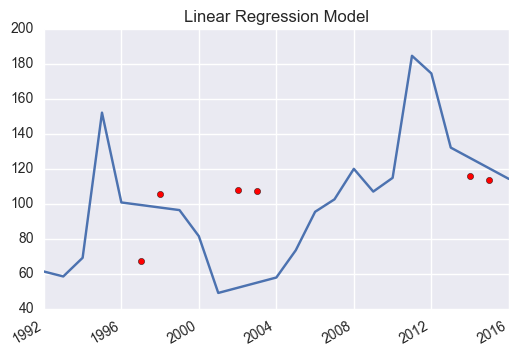

Linear model score: 0.3596706849338759
Average cross validation score (MSE): 26.060024149246903


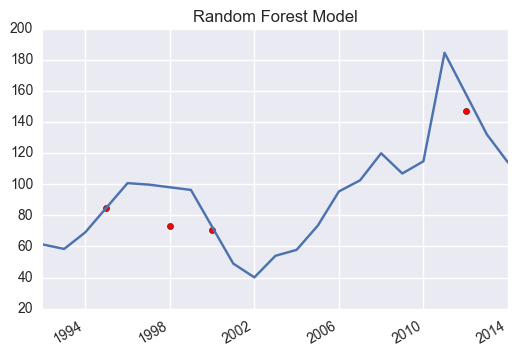

Random forest model score: 0.6789309961081579
Average cross validation score (MSE): 30.023499533410853


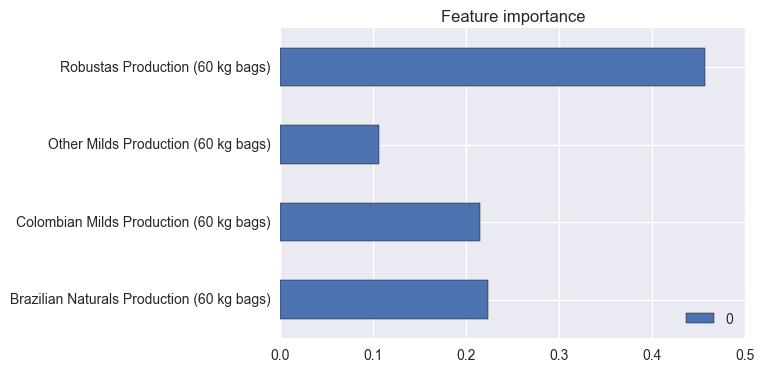

In [6]:
simple_linear_model_with_previous_production(master_dataframe)
random_forest_model_with_previous_production(master_dataframe)

## Modelling monthly ICO composite indicator from annual FAS data

In [22]:
temp_df = pd.DataFrame()
test_dataframe = master_dataframe.copy()
for category in production.ICO_categories:
#     temp_df = production.get_ending_stocks_by_ICO_category(category)
#     temp_df["Percent Change"] = temp_df["Percent Change"].replace(np.inf, np.NaN)
#     temp_df = pd.pivot_table(index = ["Market_Year"], values = ["Percent Change"], data = temp_df)
#     temp_df.columns = [category + " Ending Stock Percent Change"]
#     temp_df.index = pd.to_datetime(temp_df.index.values, format = "%Y").values
#     temp_df = temp_df[temp_df.index.year < 2017]
#     master_dataframe = pd.concat([master_dataframe, temp_df], axis = 1)
    for country in production.get_ending_stocks_by_ICO_category(category)["Country"].unique():
        temp_df = production.get_ending_stocks_by_ICO_category(category)[production.get_ending_stocks_by_ICO_category(category)["Country"] == country][["Market_Year","Percent Change"]]
        temp_df["Percent Change"] = temp_df["Percent Change"].replace(np.inf, np.NaN)
        temp_df.columns = ["Market_Year", country + " Ending Stock Percent Change"]
        temp_df.index = pd.to_datetime(temp_df["Market_Year"], format = "%Y").values
        temp_df = temp_df.drop("Market_Year", axis = 1)
        test_dataframe = pd.concat([test_dataframe, temp_df], axis = 1)

test_dataframe = test_dataframe[(test_dataframe.index.year > 1989) & (test_dataframe.index.year < 2017)]
        

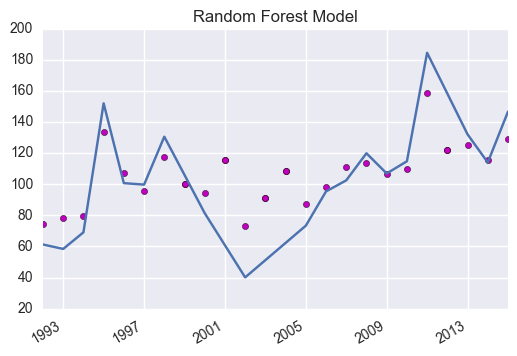

Random forest model score: 0.5791803694439737
Average cross validation score (MSE): 23.720089454497128


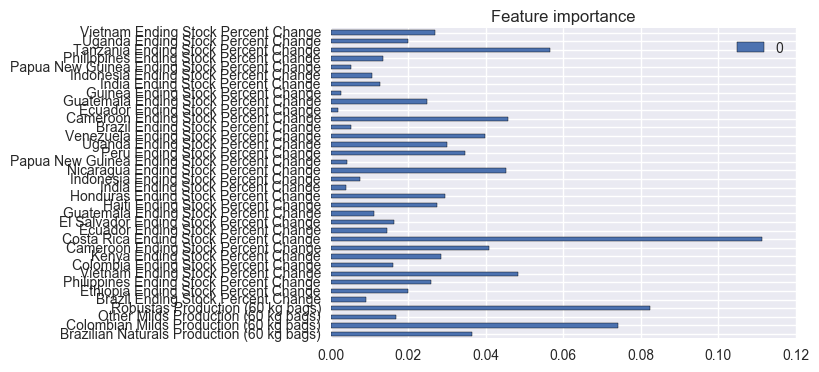

In [37]:
def random_forest_model_with_previous_production_and_ending_stocks(dataframe):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe.ix[1:, "ICO Composite Indicator (US cents/lb)"]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)

    random_forest_reg = RandomForestRegressor(n_estimators = 100)
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    plt.scatter(x = y.index, y = random_forest_reg.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    
    
    print("Random forest model score: {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))

    pd.DataFrame(data = random_forest_reg.feature_importances_, 
             index = test_dataframe.dropna(axis = 'columns').columns[1:]).plot.barh()
    plt.title("Feature importance")
    plt.show()
    
    
    return random_forest_reg
    
random_forest_reg = random_forest_model_with_previous_production_and_ending_stocks(test_dataframe.dropna(axis = 'columns'))


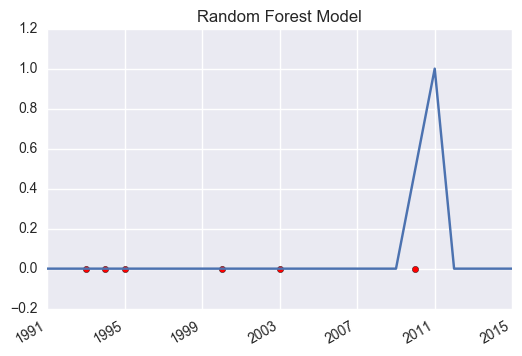

Random forest model score: 0.9615384615384616


//anaconda/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Average cross validation score (MSE): -0.95


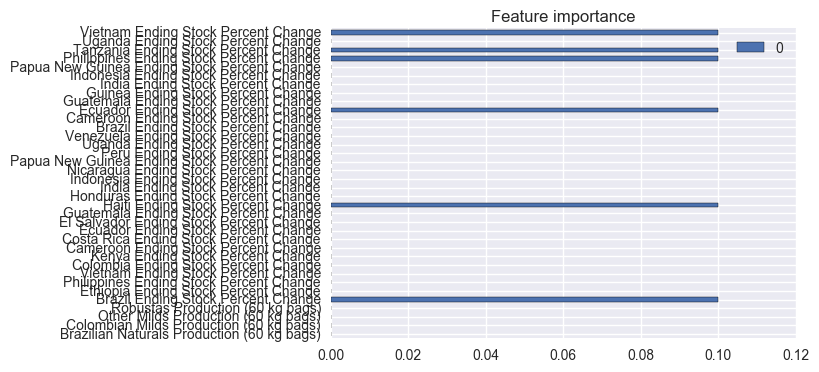

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [39]:
def random_forest_classifier_with_previous_production_and_ending_stocks(dataframe, show_actual_vs_predicted = False):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe.ix[1:, "ICO Composite Indicator (US cents/lb)"]
    
    y_greater_than_1_sigma_change = (y.to_frame().pct_change() > 0.35)
    y_greater_than_1_sigma_change.columns = ["Greater than 1 sigma pct change"]
    y_greater_than_1_sigma_change = y_greater_than_1_sigma_change["Greater than 1 sigma pct change"].map({True: 1, False: 0})
    
    train_X, test_X, train_y, test_y = train_test_split(X, y_greater_than_1_sigma_change)

    random_forest_reg = RandomForestClassifier()
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score: {}".format(random_forest_reg.score(X, y_greater_than_1_sigma_change)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y_greater_than_1_sigma_change, cv = 10).mean()))

    pd.DataFrame(data = random_forest_reg.feature_importances_, 
             index = test_dataframe.dropna(axis = 'columns').columns[1:]).plot.barh()
    plt.title("Feature importance")
    plt.show()
    
    return random_forest_reg
        
random_forest_classifier_with_previous_production_and_ending_stocks(test_dataframe.dropna(axis = 'columns'))


# Checking if PCA would help

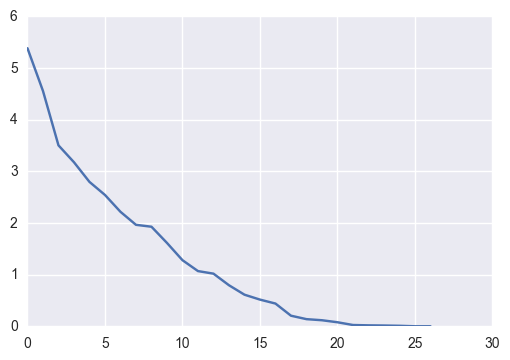

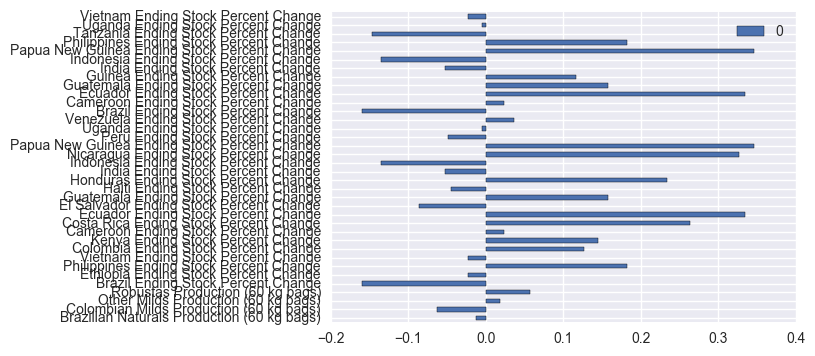

In [82]:
from sklearn.pipeline import Pipeline

pca = PCA()
scaler = StandardScaler()

pca_test_dataframe = test_dataframe.dropna(axis = 'columns').drop("ICO Composite Indicator (US cents/lb)", axis = 1)
pipe = Pipeline(steps = [("scaler", scaler), ('pca', pca)])

pipe.fit_transform(pca_test_dataframe)

plt.plot(pca.explained_variance_)
plt.show()
pd.DataFrame(pca.components_[0], index = test_dataframe.dropna(axis = 'columns').drop("ICO Composite Indicator (US cents/lb)", axis = 1).columns).plot(kind = 'barh')
plt.show()


# Improving random forest model

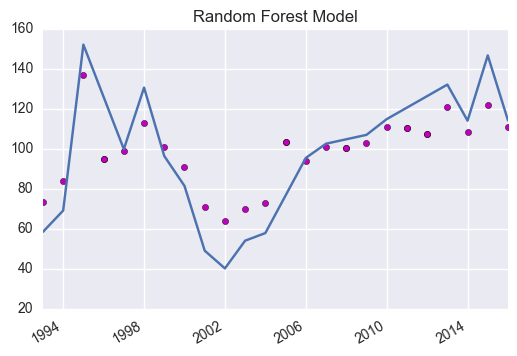

Random forest model score: 0.5151705678169657
Average cross validation score (MSE): 30.482350580760407


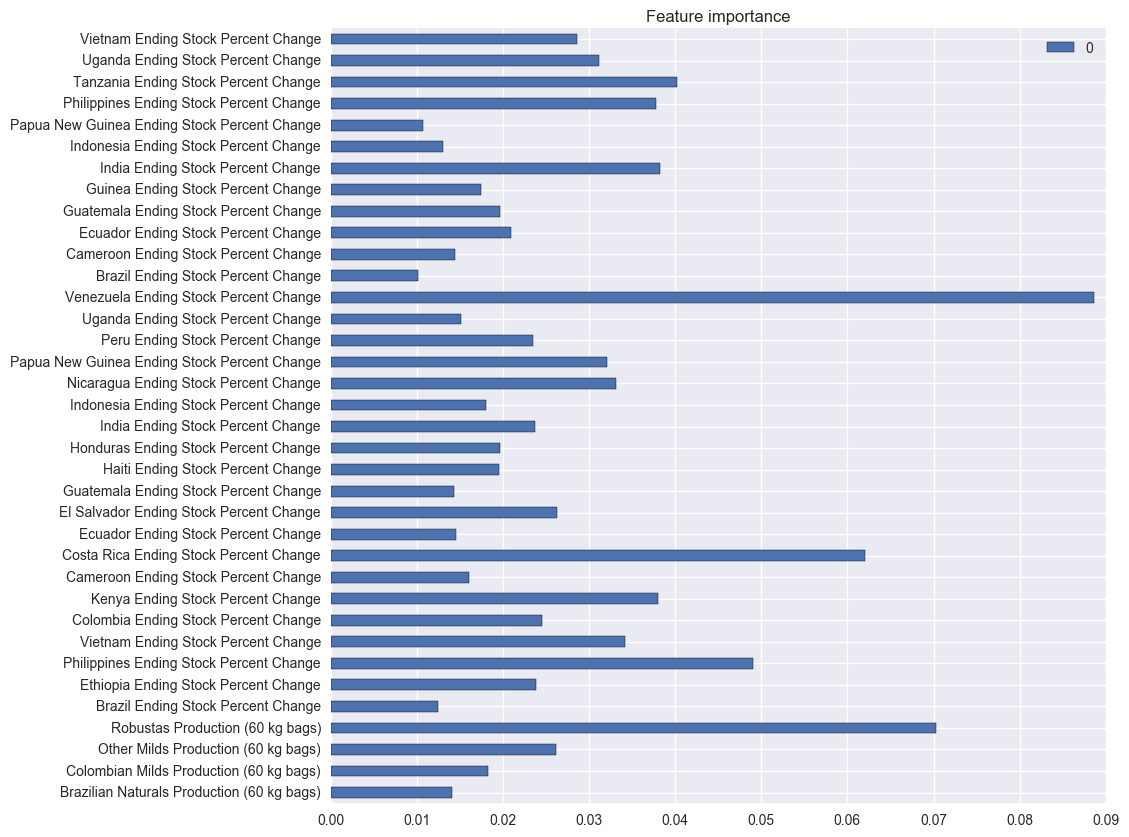

In [88]:
def improved_random_forest_model(dataframe, show_all_predictions = False):
    X = dataframe.drop("ICO Composite Indicator (US cents/lb)", axis = 1).iloc[0:-1]
    y = dataframe.ix[1:, "ICO Composite Indicator (US cents/lb)"]
    
    train_X, test_X, train_y, test_y = train_test_split(X, y)
    
    random_forest_reg = RandomForestRegressor(n_estimators = 100, max_features = "sqrt")
    random_forest_reg.fit(train_X, train_y)

    train_y.plot()
    plt.scatter(x = test_y.index, y = random_forest_reg.predict(test_X), c ="r")
    if show_all_predictions == True:
        plt.scatter(x = y.index, y = random_forest_reg.predict(X), c ="m")
    plt.title("Random Forest Model")
    plt.show()
    
    print("Random forest model score: {}".format(random_forest_reg.score(X, y)))
    print("Average cross validation score (MSE): {}".format(- cross_val_score(random_forest_reg, X, y, cv = 10).mean()))


    pd.DataFrame(data = random_forest_reg.feature_importances_, 
             index = dataframe.columns[1:]).plot.barh(figsize = (10, 10))    
    plt.title("Feature importance")
    plt.show()
    
    
    return random_forest_reg
    
random_forest_reg = improved_random_forest_model(test_dataframe.dropna(axis = 'columns'), show_all_predictions = True)

# Add precipitation data

## Examine frost before harvest

* 9 months for Arabica 
* 10-11 months for Robusta